In [1]:
import torchvision.datasets as datasets
import os 
import numpy as np
from tqdm import tqdm
from torchvision import transforms
#generate triplet face dataset from folders of images

class TripletFaceDataset(datasets.ImageFolder):
    def __init__(self, dir, n_triplets, transform=None):
        super(TripletFaceDataset, self).__init__(dir, transform)
        self.n_triplets = n_triplets
        print("Generating {} triplets...".format(self.n_triplets))
        self.training_triplets = self.generate_triplets(self.imgs, self.n_triplets, len(self.classes))
    @staticmethod
    def generate_triplets(imgs, num_triplets, n_classes):
        def create_indices(_imgs):
            inds = dict()
            for idx, (img_path, label) in enumerate(_imgs):
                if label not in inds:
                    inds[label] = []
                inds[label].append(img_path)
            return inds
        triplets = []
        indices = create_indices(imgs)
        for x in tqdm(range(num_triplets)):
            c1 = np.random.randint(0, n_classes-1)
            c2 = np.random.randint(0, n_classes-1)
            while len(indices[c1]) < 2:
                c1 = np.random.randint(0, n_classes-1)

            while c1 == c2:
                c2 = np.random.randint(0, n_classes-1)
            if len(indices[c1]) == 2:  # hack to speed up process
                n1, n2 = 0, 1
            else:
                n1 = np.random.randint(0, len(indices[c1]) - 1)
                n2 = np.random.randint(0, len(indices[c1]) - 1)
                while n1 == n2:
                    n2 = np.random.randint(0, len(indices[c1]) - 1)
            if len(indices[c2]) ==1:
                n3 = 0
            else:
                n3 = np.random.randint(0, len(indices[c2]) - 1)
            triplets.append([indices[c1][n1], indices[c1][n2], indices[c2][n3],c1,c2])
        return triplets
    def __getitem__(self, index):
        def transform(img_path):
            """Convert image into numpy array and apply transformation
               Doing this so that it is consistent with all other datasets
               to return a PIL Image.
            """
        
            img = self.loader(img_path)
            return self.transform(img)
        a, p, n,c1,c2 = self.training_triplets[index]

        # transform images if required
        img_a, img_p, img_n = transform(a), transform(p), transform(n)
        return img_a, img_p, img_n,c1,c2

    def __len__(self):
        return len(self.training_triplets)


dir = 'gray_set'
num_triplets = 20
dataset = TripletFaceDataset(dir, num_triplets, transform=transforms.ToTensor())
for step, (img_a, img_p, img_n, c1, c2) in enumerate(dataset):
    print(step, img_a.shape, img_p.shape, img_n.shape, c1, c2)

Generating 20 triplets...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 60523.87it/s]

0 torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) 2107 185
1 torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) 4684 3274
2 torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) 300 1857
3 torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) 3812 1479
4 torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) 795 4929
5 torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) 4877 2639
6 torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) 5106 2079
7 torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) 4519 2663
8 torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) 3536 2829
9 torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) 2355 10
10 torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) torch.Size([3, 250, 250]) 3642 4403
11 torch.Size(

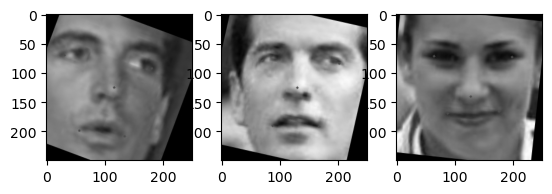

In [2]:
import matplotlib.pyplot as plt
plt.subplot(1, 3, 1)
plt.imshow(img_a.permute(1, 2, 0).numpy())
plt.subplot(1, 3, 2)
plt.imshow(img_p.permute(1, 2, 0).numpy())
plt.subplot(1, 3, 3)
plt.imshow(img_n.permute(1, 2, 0).numpy())

In [3]:
dir = 'gray_set'
num_triplets = 20000
dataset = TripletFaceDataset(dir, num_triplets, transform=transforms.ToTensor())

Generating 20000 triplets...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 90429.27it/s]


In [4]:
import torch
from torch import nn

net_front = nn.Sequential(nn.Conv2d(3, 64, (7, 7), 2, 3),
                          nn.ReLU(),
                          nn.AvgPool2d((3, 3), 2),
                          nn.BatchNorm2d(64),
                          nn.Conv2d(64, 64, (1, 1), 1, 0),
                          nn.ReLU(),
                          nn.Conv2d(64, 192, (3, 3), 1, 1),
                          nn.ReLU(),
                          nn.BatchNorm2d(192),
                          nn.MaxPool2d((3, 3), 2),
                          nn.Conv2d(192, 192, (1, 1), 1, 0),
                          nn.ReLU(),
                          nn.Conv2d(192, 384, (3, 3), 1, 1),
                          nn.ReLU(),
                          nn.MaxPool2d((3, 3), 2),
                          nn.Conv2d(384, 384, (1, 1), 1, 0),
                          nn.ReLU(),
                          nn.Conv2d(384, 256, (3, 3), 1, 1),
                          nn.ReLU(),
                          nn.Conv2d(256, 256, (1, 1), 1, 0),
                          nn.ReLU(),
                          nn.Conv2d(256, 256, (3, 3), 1, 1),
                          nn.ReLU(),
                          nn.Conv2d(256, 256, (1, 1), 1, 0),
                          nn.ReLU(),
                          nn.Conv2d(256, 256, (3, 3), 1, 1),
                          nn.ReLU(),
                          nn.MaxPool2d((3, 3), 2),
                          nn.Flatten(),
                          nn.Linear(256*6*6, 4096),
                          nn.ReLU(),
                          nn.Linear(1*32*128, 1*32*128),
                          nn.ReLU(),
                          nn.Linear(1*32*128, 1*1*128)
)


In [14]:
def train_output(net_front,net_output, epochs, train_datasets, test_datasets, device='cpu', lr=1e-3, optimizer='Adam', criterion='CrossEntropyLoss',margin=1.0, p=2):
    if optimizer == 'SGD':
        trainer = torch.optim.SGD(net_output.parameters(), lr=lr)
    elif optimizer == 'Adam':
        trainer = torch.optim.Adam(net_output.parameters(), lr=lr)

    if criterion == 'MSELoss':
        loss_1 = nn.MSELoss().to(device)
    elif criterion == 'CrossEntropyLoss':
        loss_1 = nn.CrossEntropyLoss().to(device)
    elif criterion == 'TripletMarginLoss':
        loss_1 = nn.TripletMarginLoss(margin=margin, p=p)
    train_accs = []
    test_accs = []
    net_front.requires_grad = False
    net_front.to(device)
    for epoch in range(epochs):
        net_output.to(device)
        total = 0
        correct = 0
        running_loss = 0
        train_times = 0
        net_output.train()
        for step, (a, b, y) in enumerate(tqdm(train_datasets)):
            a = net_front(a.to(device))
            b = net_front(b.to(device))
            x = torch.cat((a, b), 1)
            y = y.to(device)
            #print(x, x.shape)
            #print(x, x.shape, y, y.shape)
            # print(torch.tensor(y, dtype=torch.long), torch.tensor(y, dtype=torch.long).shape)
            if criterion == 'CrossEntropyLoss':
                y_one_hot = y.squeeze().long()
            else:
                y_one_hot = F.one_hot(torch.tensor(y, dtype=torch.int64), 2).float().squeeze().to(device)
            out = net_output(x)
            #print(y_one_hot.shape)
            # print(y_one_hot, out, y_one_hot.shape, out.shape)
            loss = loss_1(out, y_one_hot)
            trainer.zero_grad()
            loss.backward()
            trainer.step()
            total += float(x.size(0))
            # print(out, y, loss, out.shape, y.shape)
            _, output = out.max(1)
            correct += float(output.eq(y.clone().detach().squeeze()).sum())
            running_loss += loss.item()
            train_times += 1
        train_accuracy = correct / total
        train_loss = running_loss / train_times
        train_accs.append(train_accuracy)
        with torch.no_grad():
            total = 0
            correct = 0
            for step, (a, b, y) in enumerate(tqdm(test_datasets)):
                a = net_front(a.to(device))
                b = net_front(b.to(device))
                x = torch.cat((a, b), 1)
                y = y.to(device)
                out = net_output(x)
                if criterion == 'CrossEntropyLoss':
                    y_one_hot = y.squeeze().long()
                else:
                    y_one_hot = F.one_hot(torch.tensor(y, dtype=torch.int64), 2).float().squeeze().to(device)
                #print(y, out, y_one_hot, y.shape, out.shape, y_one_hot.shape)
                loss = loss_1(out, y_one_hot)
                total += float(x.size(0))
                _, output = out.max(1)
                correct += float(output.eq(y.squeeze()).sum())
                # print(out, y_one_hot, output, y.squeeze(),total,correct)
            test_accuracy = correct / total
            test_accs.append(test_accuracy)
        print('epoch %d, train loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_loss, train_accuracy, test_accuracy))
    return train_accs, test_accs

In [6]:
def plot_accs(train_accs, test_accs):
    plt.plot(train_accs, label='train acc')
    plt.plot(test_accs, label='test acc')
    plt.legend()
    plt.show()

In [7]:
def train_triplet(net, epochs, train_datasets, device='cpu', lr=1e-3, optimizer='Adam',margin=1.0, p=2):
    if optimizer == 'SGD':
        trainer = torch.optim.SGD(net.parameters(), lr=lr)
    elif optimizer == 'Adam':
        trainer = torch.optim.Adam(net.parameters(), lr=lr)
    loss_1 = nn.TripletMarginLoss(margin=margin, p=p)
    losses = []

    for epoch in range(epochs):
        net.to(device)
        total = 0
        correct = 0
        running_loss = 0
        train_times = 0
        net.train()
        for step, (a, p, n, c1, c2) in enumerate(tqdm(train_datasets)):
            
            loss = loss_1(net(a.to(device)), net(p.to(device)), net(n.to(device)))
            trainer.zero_grad()
            loss.backward()
            trainer.step()
            total += float(a.size(0))
            running_loss += loss.item()
            train_times += 1
        train_loss = running_loss / train_times
        losses.append(train_loss)
        print('epoch %d, train loss %.4f' % (epoch + 1, train_loss))
    return losses

In [8]:
def plot_loss(losses):
    plt.plot(losses, label='loss')
    plt.legend()
    plt.show()

In [9]:
dir = 'gray_set'
num_triplets = 20000
dataset = TripletFaceDataset(dir, num_triplets, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset,batch_size=256, shuffle=True)

Generating 20000 triplets...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 75920.02it/s]


In [11]:
train_loss = train_triplet(net_front, 5, dataloader, device='cuda:0')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:41<00:00,  1.29s/it]


epoch 1, train loss 1.0080


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:41<00:00,  1.29s/it]


epoch 2, train loss 0.6369


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:41<00:00,  1.29s/it]


epoch 3, train loss 0.5017


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:42<00:00,  1.29s/it]


epoch 4, train loss 0.4424


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:42<00:00,  1.29s/it]

epoch 5, train loss 0.3828


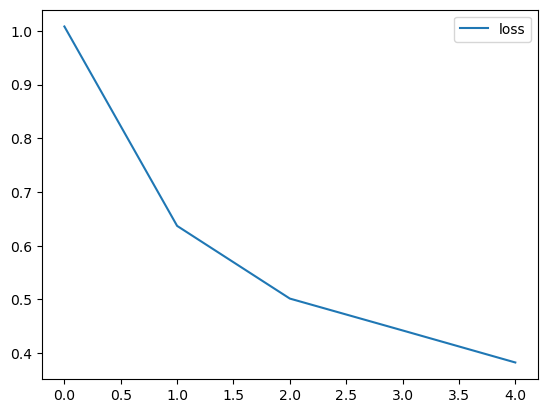

In [12]:
plot_loss(train_loss)

In [13]:
#import pdb
#pdb.set_trace()
model_dir = './facenet'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
#print(net.device)
torch.save(net_front.state_dict(), os.path.abspath('margin1_epoch5.pkl'))

In [14]:
train_loss = train_triplet(net_front, 5, dataloader, device='cuda:0', margin=0.5, p=2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:41<00:00,  1.28s/it]


epoch 1, train loss 0.1850


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:41<00:00,  1.28s/it]


epoch 2, train loss 0.1511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:41<00:00,  1.28s/it]


epoch 3, train loss 0.1313


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:41<00:00,  1.29s/it]


epoch 4, train loss 0.1204


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:41<00:00,  1.28s/it]

epoch 5, train loss 0.1023


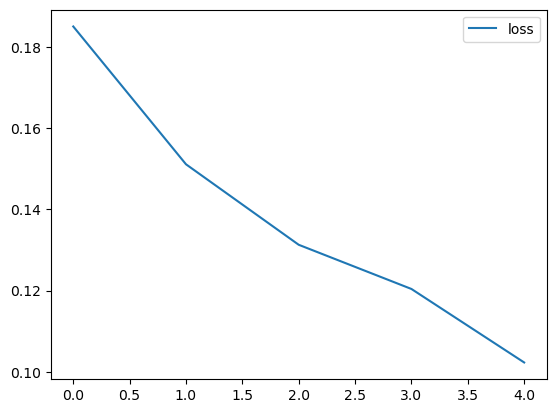

In [15]:
plot_loss(train_loss)

In [16]:
#import pdb
#pdb.set_trace()
model_dir = './facenet'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
#print(net.device)
torch.save(net_front.state_dict(), os.path.abspath('margin0.5_epoch5.pkl'))

In [20]:
net_output = nn.Sequential(nn.Linear(128*2, 256*2),
                          nn.ReLU(),
                          nn.Linear(256*2, 256*2),
                          nn.ReLU(),
                          nn.Linear(256*2, 128),
                          nn.ReLU(),
                          nn.Linear(128, 64),
                          nn.ReLU(),
                          nn.Linear(64, 16),
                          nn.ReLU(),
                          nn.Linear(16, 2))

In [21]:
net_front.load_state_dict(torch.load(os.path.abspath('margin0.5_epoch5.pkl')))
net_front.requires_grad = False

In [18]:
class Pairs_Dataset(datasets.ImageFolder):
    def __init__(self, dir, n_pairs, transform=None):
        super(Pairs_Dataset, self).__init__(dir, transform)
        self.n_pairs = n_pairs
        print("Generating{} pairs...".format(self.n_pairs))
        self.training_pairs = self.generate_pairs(self.imgs, self.n_pairs, len(self.classes))
    @staticmethod
    def generate_pairs(imgs, num_pairs, n_classes):
        def create_indices(_imgs):
            inds = dict()
            for idx, (img_path, label) in enumerate(_imgs):
                if label not in inds:
                    inds[label] = []
                inds[label].append(img_path)
            return inds
        pairs = []
        indices = create_indices(imgs)
        for x in tqdm(range(num_pairs)):
            if x<num_pairs/2:
                c1 = np.random.randint(0, n_classes-1)
                while len(indices[c1])<2:
                    c1=np.random.randint(0, n_classes-1)
                c2 = c1
                if len(indices[c1])==2:
                    n1 = 0
                    n2 = 1
                else:
                    n1 = np.random.randint(0, len(indices[c1])-1)
                    n2 = np.random.randint(0, len(indices[c2])-1)
                    while n2==n1:
                        n2 = np.random.randint(0, len(indices[c2])-1)
            else:
                c1 = np.random.randint(0, n_classes-1)
                c2 = np.random.randint(0, n_classes-1)
                while c1==c2:
                    c2 = np.random.randint(0, n_classes-1)
                if len(indices[c1])==1:
                    n1 = 0
                else:
                    n1 = np.random.randint(0, len(indices[c1])-1)
                if len(indices[c2])==1:
                    n2 = 0
                else:
                    n2 = np.random.randint(0, len(indices[c2])-1)
                
            pairs.append([indices[c1][n1], indices[c2][n2], (c1==c2)])
        return pairs
    def __getitem__(self, index):
        def transform(img_path):
            img = self.loader(img_path)
            return self.transform(img)
        a, b, is_same = self.training_pairs[index]
        img_a, img_b = transform(a), transform(b)
        return img_a, img_b, is_same
    def __len__(self):
        return len(self.training_pairs)

In [22]:
dir = 'gray_set'
num_triplets = 20000
dataset_pairs = Pairs_Dataset(dir, num_triplets, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset_pairs,batch_size=256, shuffle=True)
dataset_test = Pairs_Dataset(dir, int(num_triplets/10), transform=transforms.ToTensor())
dataloader_test = torch.utils.data.DataLoader(dataset_pairs,batch_size=256, shuffle=True)

Generating20000 pairs...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 140638.97it/s]


Generating2000 pairs...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 125388.38it/s]


In [23]:
train_accs1, test_accs1 = train_output(net_front,net_output, epochs=5, train_datasets=dataloader, test_datasets=dataloader_test, device='cuda:0', lr=1e-3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.64it/s]


epoch 1, train loss 0.6424, train acc 0.604, test acc 0.757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.64it/s]


epoch 2, train loss 0.4308, train acc 0.807, test acc 0.822


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.65it/s]


epoch 3, train loss 0.3966, train acc 0.827, test acc 0.817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.68it/s]


epoch 4, train loss 0.3860, train acc 0.831, test acc 0.772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.64it/s]

epoch 5, train loss 0.3937, train acc 0.828, test acc 0.828


In [38]:
#import pdb
#pdb.set_trace()
torch.save(net_output.state_dict(), os.path.abspath('output_epoch5.pkl'))

In [25]:
dir = 'gray_set'
num_triplets = 20000
dataset_pairs = Pairs_Dataset(dir, num_triplets, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset_pairs,batch_size=256, shuffle=True)
dataset_test = Pairs_Dataset(dir, int(num_triplets/10), transform=transforms.ToTensor())
dataloader_test = torch.utils.data.DataLoader(dataset_pairs,batch_size=256, shuffle=True)

Generating20000 pairs...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 82981.09it/s]


Generating2000 pairs...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 97134.22it/s]


In [26]:
train_accs1, test_accs1 = train_output(net_front,net_output, epochs=5, train_datasets=dataloader, test_datasets=dataloader_test, device='cuda:0', lr=1e-3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.66it/s]


epoch 1, train loss 0.3975, train acc 0.827, test acc 0.841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.67it/s]


epoch 2, train loss 0.3787, train acc 0.836, test acc 0.833


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.67it/s]


epoch 3, train loss 0.3823, train acc 0.833, test acc 0.827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.66it/s]


epoch 4, train loss 0.3795, train acc 0.835, test acc 0.837


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.66it/s]

epoch 5, train loss 0.3758, train acc 0.835, test acc 0.838


In [39]:
torch.save(net_output.state_dict(), os.path.abspath('output_epoch10.pkl'))

In [40]:
import utils


In [50]:
def predict(imga, imgb):
    a = torch.tensor([utils.face_alignment(imga, is_gray=False)]).permute(0, 3, 1, 2).float()
    b = torch.tensor([utils.face_alignment(imgb, is_gray=False)]).permute(0, 3, 1, 2).float()
    net1 = net_front
    net1.load_state_dict(torch.load(os.path.abspath('margin0.5_epoch5.pkl')))
    net1.requires_grad = False
    net1.to('cpu')
    net2 = net_output
    net2.load_state_dict(torch.load(os.path.abspath('output_epoch10.pkl')))
    net2.requires_grad = False
    net2.to('cpu')
    a = net1(a)
    b = net1(b)
    x = torch.cat((a, b), 1)
    out = net2(x)
    _, output = out.max(1)
    return output
    

In [51]:
import cv2
for i in range(600):
        A = cv2.imread('../../data/test_pair/{}/A.jpg'.format(str(i)))
        B = cv2.imread('../../data/test_pair/{}/B.jpg'.format(str(i)))
        out = predict(A, B)
        fp = open('result_facenet.txt', 'a')
        if out==1:
            fp.write('1\n')
        else:
            fp.write('0\n')
        fp.close()